https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

위의 데이터셋을 불러와서 분류하는 모델을 만들어봅시다. 


Custom Dataset에 Transform을 추가해봅시다. 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
from PIL import Image

class Brain(Dataset):
    def __init__(self, path = None, transform=None): # transform을 입력할 수 있는 옵션 추가
        self.transform = transform # 내부 변수에 저장
        if path is None: path = '/content/drive/MyDrive/Teaching/DL 202301/brain_tumar'

        imgs = []
        
        # yes 폴더에 있는 파일 불러오기
        files = os.listdir(path+'/yes') 
        for file in files:  # 파일명 순회
          try:
            file_path = os.path.join(path+'/yes', file) # 경로 + 파일명
            img = Image.open(file_path).convert('RGB') # RGB로 이미지 열기
            img = self.transform(img)
            imgs.append((img, 1)) # 리스트에 추가   # yes = 1로 지정
          except:
            print(img.size, file)
        
        files = os.listdir(path+'/no')  
        for file in files:  # 파일명 순회
          file_path = os.path.join(path+'/no', file) # 경로 + 파일명
          img = Image.open(file_path).convert('RGB') # 이미지 열기
          img = self.transform(img)
          imgs.append((img, 0)) # 리스트에 추가   # no = 0으로 지정

        # 내부 변수에 저장
        self.data = imgs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

적용할 transform을 작성해봅시다

https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.MobileNet_V3_Small_Weights

In [2]:
# 데이터셋에 적용할 변환 정의
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # 이미지 리사이즈
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
brain_data = Brain(transform=transform)

In [4]:
brain_data[0][0].shape

torch.Size([3, 224, 224])

In [5]:
brain_data[0][0].max()

tensor(1.9428)

In [6]:
brain_data[0][0].min()

tensor(-2.1179)

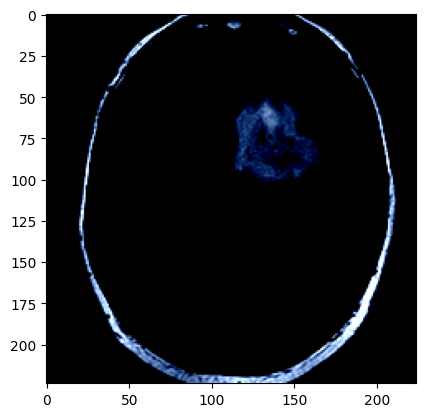

In [7]:
import matplotlib.pyplot as plt

plt.imshow(brain_data[0][0].numpy().transpose(1,2,0))

위의 결과를 보면 세부 정보가 전처리 단계에서 많이 사라졌습니다. 

전처리에 따라 학습이 잘 될수도 있고, 그렇지 않은 경우도 있습니다

모바일넷으로 학습해봅시다



In [8]:
import torchvision.models as models
model = models.mobilenet_v3_small()

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
from torchsummary import summary
summary(model, (3, 224, 224))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

마지막층을 2진 분류가 가능하도록 고정합니다. 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
model.classifier[-1] = nn.Linear(in_features=1024, out_features=2, bias=True)

이제 학습을 위해 dataloader를 만들어보겠습니다. 

dataset에서 데이터가 섞여있지 않으므로 dataloader에서 shuffle=True를 적용합니다. 

In [13]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(brain_data, batch_size=batch_size, shuffle=True)

이제 학습을 해보겠습니다. 

validation, test set을 안 만들었으므로, 학습만 해보겠습니다. 

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [16]:
from tqdm import tqdm

size = len(train_loader.dataset)  # 데이터셋 길이 확인
model.train()   # 모델을 훈련모드로 

epochs = 10
losses = []  # epoch마다 loss 변화 저장 변수
acces = []  # epoch마다 acc변화 저장 변수

for i in range(epochs):

  model.train() # 학습 모드
  model = model.to(device)
  train_loss, correct = 0, 0  # loss와 정확도 계산 목적
  for X, y in tqdm(train_loader): # tqdm으로 진행상황 확인 가능
      X, y = X.to(device), y.to(device) 
      # Compute prediction error
      pred = model(X)  # 예측 계산
      loss = loss_fn(pred, y)  # loss 계산
      train_loss += loss.item()  # loss 누적
      correct += (pred.argmax(1) == y).sum()  # 맞춘 개수 확인

      # Backpropagation
      optimizer.zero_grad()  # gradient 초기화
      loss.backward()   # gradient 계산
      optimizer.step()   # w,b 반영

  # train 데이터셋에 대한 정확도 계산                
  acc = correct/size  
  losses.append(loss.item())
  acces.append(acc.item())
  print('epoch:',i+1)
  print(f"loss: {train_loss:>7f}  acc:{acc:>5f}")


100%|██████████| 8/8 [00:01<00:00,  4.45it/s]


epoch: 1
loss: 5.783982  acc:0.671937


100%|██████████| 8/8 [00:00<00:00, 14.68it/s]


epoch: 2
loss: 3.277584  acc:0.830040


100%|██████████| 8/8 [00:00<00:00, 30.79it/s]


epoch: 3
loss: 1.469691  acc:0.924901


100%|██████████| 8/8 [00:00<00:00, 31.15it/s]


epoch: 4
loss: 0.905162  acc:0.952569


100%|██████████| 8/8 [00:00<00:00, 29.70it/s]


epoch: 5
loss: 0.712554  acc:0.972332


100%|██████████| 8/8 [00:00<00:00, 31.02it/s]


epoch: 6
loss: 1.304332  acc:0.944664


100%|██████████| 8/8 [00:00<00:00, 31.13it/s]


epoch: 7
loss: 0.667694  acc:0.976285


100%|██████████| 8/8 [00:00<00:00, 31.20it/s]


epoch: 8
loss: 0.369744  acc:0.992095


100%|██████████| 8/8 [00:00<00:00, 31.06it/s]


epoch: 9
loss: 0.184910  acc:0.992095


100%|██████████| 8/8 [00:00<00:00, 30.58it/s]

epoch: 10
loss: 0.091344  acc:0.996047
